In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
from munkres import Munkres

**I - Data generation and manipulation**

In this practical session we will use two datasets :
- a first simple one, to understand how the SPA iterations work ;
- a real hyperspectral one, called urban.
Urban is one of the most widely used hyperspectral data used for hyperspectral unmixing studies. There are 307 x 307 pixels, each of which corresponds to a 2 x 2 m2 area. There are 210 wavelengths ranging from 400 nm  to 2500 nm, resulting in a spectral resolution of 10 nm. After the channels 1--4, 76, 87, 101--111, 136--153 and 198--210 are removed (due to dense water vapor and atmospheric effects), we obtain 162  channels.
Interestingly enough, a ground truth have been established. The one we will use contains 6 endmembers (i.e. sources).

**1) Simple dataset**

We propose to generate a very simple dataset, for visual purposes, as follows:
- the mixing matrix **A** will be a m x n matrix with its coefficients generated randomly in [0,10]. When you obtain such a realisation, verify that **A** is not too badly conditioned.
- the source matrix **S** will be a n x t matrix with random coefficients in [0,1] but will be scalled so that the l1-norm of each of its columns sum to 1.
- There will be no noise.

Conditioning number of A_toy: 5.685271736873319


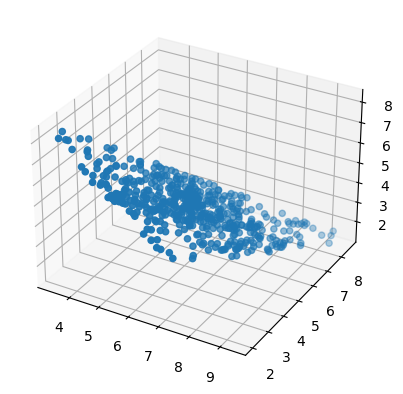

In [3]:
# TO DO : generate A according to the above description.
# TO DO : compute the condition number of A. What would be the issue with an ill-conditioned mixing matrix?
# TO DO : generate S according to the above conditions.
# TO DO : generate X with a linear mixing

n = 3
m = 3
t = 500

A_toy = 10*np.random.random((m,n))
_,S,_ = np.linalg.svd(A_toy)
cond_num = S[0]/S[-1]

S_toy = np.random.random((n,t))
sum_cs = np.sum(S_toy,axis=0)
S_toy = S_toy/sum_cs

X_toy = A_toy@S_toy

print('Conditioning number of A_toy:',cond_num)
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_toy[0,:],X_toy[1,:],X_toy[2,:])

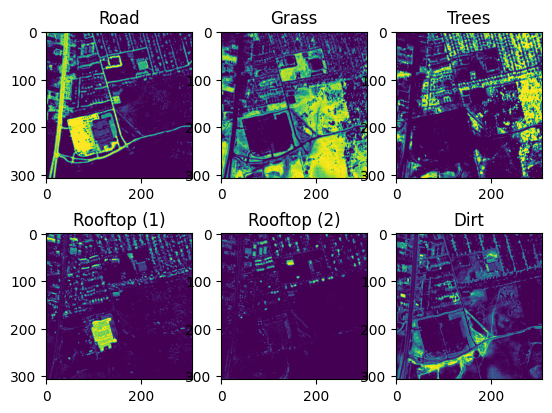

In [4]:
data = sci.loadmat('Urban.mat')
X = data['X']
X = X.astype(float) # Please take care that the data matrix must be cast to float in Python, for subsequential operations

gt = sci.loadmat('end6_groundTruth.mat')
abundances = gt['A']# Here A is a dumb variable, don't pay attention to it. The abundances are S^*.

nCol = 307
nRow = 307

names = ['Road','Grass','Trees','Rooftop (1)','Rooftop (2)','Dirt']

plt.figure()
#TO DO : try to interpret the abundances that you see. Hint : the 6 sources are usually called ['Grass','Road','Rooftop (2)','Dirt','Trees','Rooftop (1)']. Associate a name to each endmember.
for ii in range(6):
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(abundances[ii,:].reshape(nCol,nRow))

    plt.title(names[ii])


**2) Real hyperspectral data set**

First, upload in your working environment the two files Urban.mat and end6_groundTruth.mat, which can be found at https://partage.imt.fr/index.php/s/xezsotfzBndaeX9

Here, we will use the "Urban" dataset:
- The data matrix **X = AS + N**, which has been acquired by a true sensor ;
- The groundtruth **S_gt**, which corresponds to the "true" abundances (sur groundtruth can for instance be found by on earth geological inquiries). Note that having access to **S_gt** is exceptional: for most other datasets, it would be unknown.

- TO DO : is the near separable (aka pure pixel) assumption fulfilled on this dataset? Explain why.

- TO DO : we have access to the abundance **S_gt** groundtruth but not to the endmembers **A_gt**. Use your above answer to explain how the following code finds the endmembers.
In particular, explain the use of the mean function (adding some plots to your report might be beneficial here).

(<Figure size 640x480 with 1 Axes>,
  <matplotlib.lines.Line2D at 0x1e3b6a2a850>])

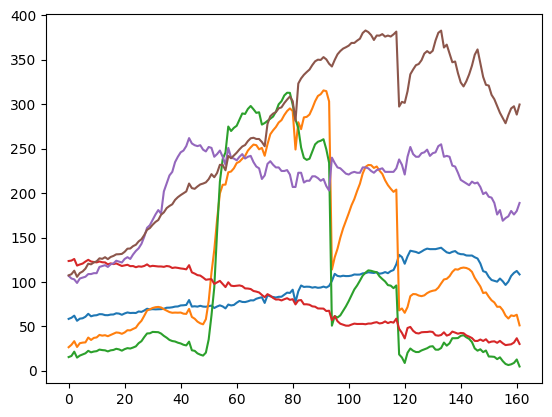

In [5]:
endmembers= np.zeros((162,6))

for ii in range(6):
    ind = np.where(abundances[ii] > 0.999)[0]
    allPP = X[:,ind]
    endmembers[:,ii] = np.mean(allPP,axis=1)


plt.figure(),plt.plot(endmembers)

Each of the above curves represents the mean spectral response of pure pixels (each curve only coutns pure pixels for one material). The data would be separable if these curves didn't overlap each other too much which isn't the case here. In particular, it seems extremely hard to separate the orange and green curves

What the above code does is: for each endmember (Grass, Dirt, Trees, Rooftop 1/2 and Road) it gets the columns corresponding to the nearly pure pixels (pixels made of only one endmember) and averages their spectral response for each channel (thus the np.mean(.,axis=1) which computes the mean on each line of the matrix). The resulting matrix corresponds to what we would want the endmembers A matrix to be.

**II - Near separable algorithm**

We will here implement the SPA (greedy) near-separable NMF algorithm and look at its practical efficiency.

1) Recall what near-separable NMF is.

Near separabale NMF is a model in which X = AS+N where A is composed by a subset of X's columns

2) Implement the SPA algorithm

In [6]:
def simpleSPA(Xin,r,optDisp=False): # TO DO.

    R = Xin.copy()

    K = np.zeros(r)

    for ii in range(r):
      if optDisp:
        fig = plt.figure()
        ax = fig.add_subplot(111,projection='3d')
        ax.scatter(R[0,:],R[1,:],R[2,:])

      p = np.argmax(np.sum(R**2,axis=0))

      K[ii] = p

      rp = R[:,p]

      R = (np.eye(R.shape[0])-np.outer(rp,rp)/(np.linalg.norm(rp)**2))@R

      print('Max residual %s'%np.max(R))

    return K.astype(int)

3) Launch the SPA algorithm on the toy example.

Plot the residual at each iteration of SPA.

How many sources can you at most extract ? Why ?

Since the residuals converge to 0 we are only limited by our machine's number representation. I didn't run into a problem before I tried extracting a 34th source, 33 is the maximum on my computer.

Max residual 7.470049214016897
Max residual 2.006130832570289
Max residual 2.0943789028733057e-15
[257 133 318]


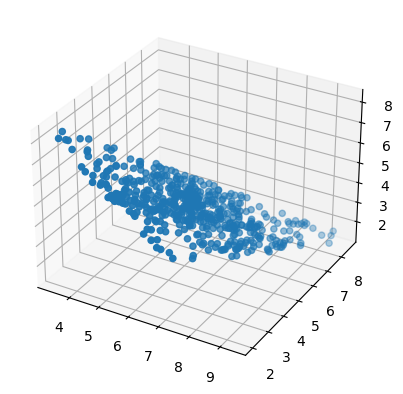

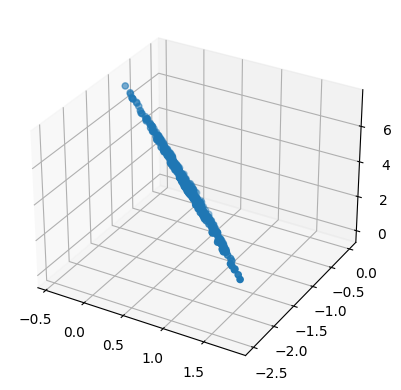

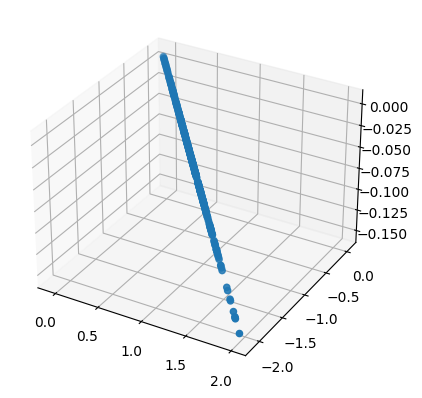

In [7]:
K_SPA = simpleSPA(X_toy,3,optDisp = True)
print(K_SPA)

**4)** The code below enables to compute a separation metric to measure the separation accuracy of the BSS algorithms.

Use the evalCriterion function to assess the quality of SPA on the real dataset.

Plot the endmembers found by your algorithm. How good are they?

We get pretty convincing endmembers thanks to the SPA, some portions of the curves don't correspond that well but for each one of them, the important parts match very closely. Those that have spikes have them in the same place, those that rise do as well, etc

In [8]:
def norm_col(A):
    An = A.copy()
    type(An)
    for ii in range(np.shape(An)[1]):
        An[:,ii] = An[:,ii]/np.sqrt(np.sum(An[:,ii]**2));

    return An




def correctPerm(W0_en,W_en):
    # [WPerm,Jperm,err] = correctPerm(W0,W)
    # Correct the permutation so that W becomes the closest to W0.

    W0 = W0_en.copy()
    W = W_en.copy()

    W0 = norm_col(W0)
    W = norm_col(W)

    costmat = -W0.T@W; # Avec Munkres, il faut bien un -


    m = Munkres()
    Jperm = m.compute(costmat.tolist())

    WPerm = np.zeros(np.shape(W0))
    indPerm = np.zeros(np.shape(W0_en)[1])

    for ii in range(W0_en.shape[1]):
        WPerm[:,ii] = W_en[:,Jperm[ii][1]]
        indPerm[ii] = Jperm[ii][1]

    return WPerm,indPerm.astype(int)




def evalCriterion(W0_en,W_en):
    # W0 : true mixing matrix
    # W : estimated mixing matrix
    #
    # maxAngle : cosine of the maximum angle between the columns of W0 and W

    W0 = W0_en.copy()
    W = W_en.copy()

    W,indPerm = correctPerm(W0,W);

    W0 = norm_col(W0_en)
    W = norm_col(W)

    diff = W0.T@W;

    return np.mean(np.diag(diff));

Max residual 603.417343707026
Max residual 503.62039752697103
Max residual 202.6288289887585
Max residual 180.78413293311738
Max residual 160.99372330966372
Max residual 163.71498109412846
evaluation score: 0.9149174369799745


(<Figure size 640x480 with 1 Axes>,
  <matplotlib.lines.Line2D at 0x1e3b6ca0990>])

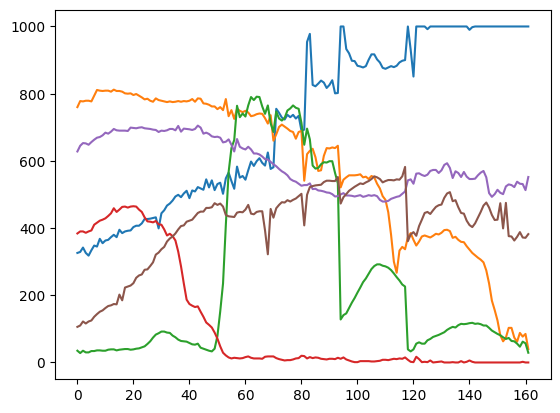

In [9]:
K = simpleSPA(X,6,optDisp=False)
A_SPA = X[:,K]

print('evaluation score:',evalCriterion(endmembers,A_SPA))
plt.figure(),plt.plot(A_SPA)

(<Figure size 640x480 with 1 Axes>,
  <matplotlib.lines.Line2D at 0x1e3b6d0f090>])

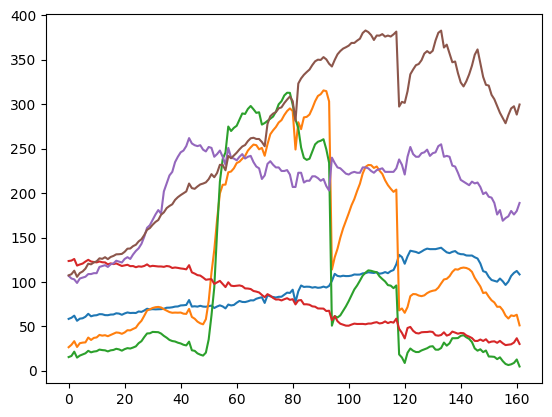

In [10]:
plt.figure(),plt.plot(endmembers)

**5)** (Bonus) The SPA algorithm gives you an estimation of the mixing matrix. Code an ISTA algorithm to obtain the corresponding sources (abundances). Plot them.

In [11]:
def prox_l1(S_est,thrd):
    S_est = np.sign(S_est)*np.maximum(np.abs(S_est)-thrd,0)
    return S_est

def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
    S_est = np.zeros((n,X.shape[1]))
    gamma = 0.9/np.linalg.norm(A.T@A)
    for k in range(nbIt):
        S_est = prox_l1(S_est-gamma*A.T@(A@S_est-X),gamma*lamb)

    return S_est

In [12]:
S_ISTA = ISTA(X,A_SPA,n=6)

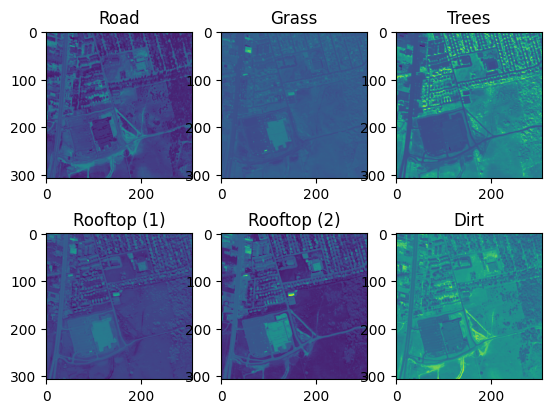

In [13]:
for ii in range(6):
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(S_ISTA[ii,:].reshape(nCol,nRow))

    plt.title(names[ii])

**III - PLAIN NMF**

In this part we use the PALM algorithm to perform plain NMF. Of course, if you already coded the PALM algorihtm with sparsity constriant in the previous TP, you can just adapt it.

This optimization scheme is simple but can provide decent separation results.

**1)** Write the cost function of plain NMF.

The cost function of plain NMF is $\frac 1 2 ||X-AS||_F^2+\iota_{.\geq 0}(S)+\iota_{.\geq 0}(A)$

**2)** Implement the proximal operator of the nonnegativity constraint.

In [14]:
def prox_positive(S): # TO DO
    S = np.maximum(S,0)
    return S

**3)** Implement the PALM algorithm to solve the plain NMF problem.

In [38]:
def PALM(X,n=2,nbIt = 100,Ainit=None,Sinit=None): # TO DO : reutiliser le PALM du TP precedent et l'adapter
     m,t = X.shape
     if Ainit is None:
          A_est = np.random.rand(m,n)
     else:
          A_est = Ainit
     if Sinit is None:
          S_est = np.random.rand(n,t)
     else:
          S_est = Sinit
     for k in range(nbIt):
          gamma = 0.9/np.linalg.norm(A_est@(A_est.T))   
          eta = 0.9/np.linalg.norm(S_est@(S_est.T))
          S_est = prox_positive(S_est-gamma*(A_est.T)@(A_est@S_est-X))
          A_est = prox_positive(A_est-eta*(A_est@S_est-X)@(S_est.T))
          
     return A_est,S_est

**4)**
Launch the PALM algorithm on the real hyperspectral dataset.

Can you find of a better initialization than the random one ?

Compare your result, both qualitatively and quantitatively, with the SPA algorithm. Explain the differences.

Plot the abundances.

Instead of a reandom initialization, we could use the output of SPA and ISTA to start closer to the minimum. \
With a random initialization, the results we get are worse than with SPA. The endmembers look like random noise and the abundances don't highlight the right regions, if they highlight any region at all. If we use the results of SPA (for A) and ISTA (for S) instead, the abundances end up not improving that much but the endmembers look way more like the ground truth though the result is a bit worse compared to PSA, we get an evaluation score of 0.89 instead of 0.91. Strangely enough, using only the result of SPA as initialization for A and starting with a random S yields a better result than with SPA alone with a score of 0.92 and the abundances look closer to the truth than before.

In [40]:
# CORRECTION
A_est,S_est = PALM(X,n=6,nbIt = 1000,Ainit=A_SPA,Sinit=None) # TO DO: modify the initialization

evaluation score: 0.9196136204753099


(<Figure size 640x480 with 1 Axes>,
  <matplotlib.lines.Line2D at 0x1e3ac1612d0>])

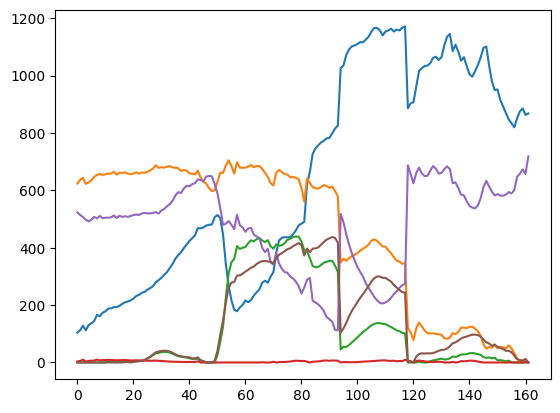

In [41]:
print('evaluation score:',evalCriterion(endmembers,A_est))
plt.figure(),plt.plot(A_est)

(<Figure size 640x480 with 1 Axes>,
  <matplotlib.lines.Line2D at 0x1e3b69bc810>])

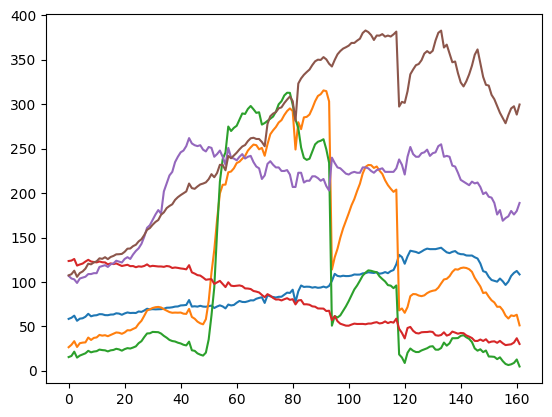

In [42]:
plt.figure(),plt.plot(endmembers)

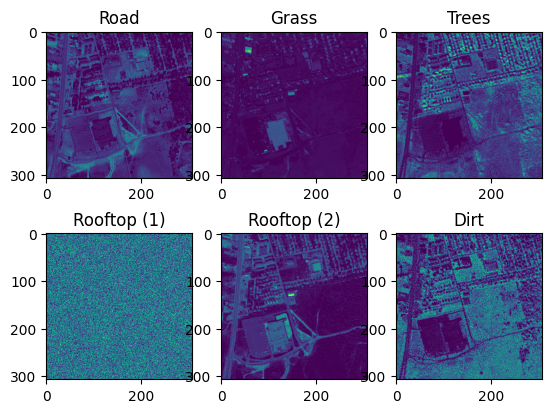

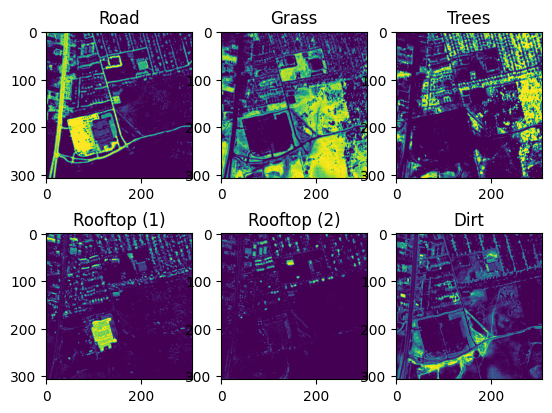

In [43]:
for ii in range(6):
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(S_est[ii,:].reshape(nCol,nRow))

    plt.title(names[ii])
plt.show()

for ii in range(6):
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(abundances[ii,:].reshape(nCol,nRow))

    plt.title(names[ii])
plt.show()

**IV - MINIMUM VOLUME NMF**

We finish this TP with the utilization of minimum volume NMF. As coding the corresponding algorithm is slightly above the objective of the classes, the code is fully given below.

In [21]:
def simplexProx(X,epsilon = 0):
#     Given X,  computes its projection Y onto the simplex

#       Delta = { x | x >= 0 and sum(x) <= 1 },

# that is, Y = argmin_z ||x-X||_2  such that z in S.

# If X is a matrix, is projects its columns onto Delta to generate Y.


# ****** Input ******
# X       : m-by-r matrix
# epsilon : r-by-1 vector, generally positive and taken = 0

# ****** Output ******
# Y       : the projected matrix


    if np.isscalar(epsilon) == 1:
        epsilon = epsilon*np.ones(np.shape(X)[1])

    Y = np.zeros(np.shape(X))

    for ii in range(np.shape(X)[1]): # The prox is separable over the columns of X
        x = X[:,ii].copy() # We work on each column separately
        xsort = np.sort(x) # We need to sort the x value to apply the dichotomy

        index_min=0 # Index values for the dichotomy
        index_max=len(x)-1;

        # mu s.t. x_i > mu-epsilon, forall i
        mu_min=xsort[0]+epsilon[ii] # mu is the parameter required for the projection

        min_sum=np.sum(x)-len(x)*mu_min

        if min_sum < 1:# If the vector already satisfies the sum to at most one constraint
            mu=(np.sum(x)-1.)/float(len(x))
            y=np.maximum(-epsilon[ii]*np.ones(len(x)), x-mu) # Element-wise max
            Y[:,ii]=y;
        else:
            # Use dichotomy for finding the optimal mu value
            stop = False
            it = 0
            while stop == False:
                it += 1

                cur_ind = int(np.round((float(index_min)+float(index_max)+1e-6)/2.))
                mu=xsort[cur_ind]+epsilon[ii]
                y=np.maximum(-epsilon[ii]*np.ones(len(x)), x-mu)

                val_constr = np.sum(y)
                if val_constr < 1.:
                    index_max=cur_ind # Because the objective is decreasing with mu and indMax > indMin
                elif val_constr > 1.:
                    index_min=cur_ind

                else: # We found the best mu
                    Y[:,ii]=y
                    stop = True


                if index_max == index_min + 1:# This is a stopping condition, as the constraint function is piecewise linear
                    stop = True


            mu_inf=xsort[index_min]+epsilon[ii];
            mu_sup=xsort[index_max]+epsilon[ii];
            constr_inf = np.sum(np.maximum(-epsilon[ii]*np.ones(len(x)),x-mu_inf))
            constr_sup = np.sum(np.maximum(-epsilon[ii]*np.ones(len(x)),x-mu_sup))

            slope=(constr_sup-constr_inf)/(mu_sup-mu_inf)
            mu_opt=(1.-constr_inf)/slope+mu_inf # Because the constraint function is piecewise linear

            # Compute the corresponding column of Y
            y=np.maximum(-epsilon[ii]*len(x), x-mu_opt)

            Y[:,ii]=y



    return Y




#%%
def FGM_MM_nonneg(A,C,W0=0,maxiter=500,proj=1):
    # Fast gradient method to solve nonnegative least squares.
    # See Nesterov, Introductory Lectures on Convex Optimization: A Basic
    # Course, Kluwer Academic Publisher, 2004.

    # This code solves:

    #     min_{x_i in R^r_+} sum_{i=1}^m ( x_i^T A x_i - 2 c_i^T x_i ), if proj == 1
    #     min_{x_i in S} sum_{i=1}^m ( x_i^T A x_i - 2 c_i^T x_i ), if proj == 2 (with S = simplex)
    # [W,e] = FGMfcnls(A,C,W0,maxiter)

    # ****** Input ******
    # A      : Hessian for each row of W, positive definite
    # C      : linear term <C,W>
    # W0     : m-by-r initial matrix
    # maxiter: maximum numbre of iterations (default = 500).
    # proj   : =1, nonnegative orthant
    #          =2, nonnegative orthant + sum-to-one constraints on columns
    #
    # ****** Output ******
    # W      : approximate solution of the problem stated above.
    # e      : e(i) = error at the ith iteration

    if np.isscalar(W0):
        W0 = np.zeros(np.shape(C));

    L = np.linalg.norm(A,2)# Pas evident...
    e = np.zeros(maxiter)
    # Extrapolation parameter
    beta = (1.-np.sqrt(np.linalg.cond(A))) / (1. + np.sqrt(np.linalg.cond(A)));

    # Project initialization onto the feasible set
    if proj == 1:
        W = np.maximum(W0,0)
    elif proj == 2:
        W = simplexProx(W0)


    Y = W # Initialization of the second sequence (for the acceleration)
    ii = 0;
    eps0 = 0.
    eps = 1.
    delta = 1e-6

    while ii < maxiter and eps >= delta*eps0:
        # print("FGM_MM_nonneg, it %s"%ii)
        # Previous iterate
        Wp = W

        # FGM Coefficients
        # alpha(i+1) = ( sqrt(alpha(i)^4 + 4*alpha(i)^2 ) - alpha(i)^2) / (2);
        # beta(i) = alpha(i)*(1-alpha(i))/(alpha(i)^2+alpha(i+1));

        # Projected gradient step from Y
        W = Y - (Y@A-C) / L

        # Projection
        if proj == 1:
            W = np.maximum(W,0.)
        elif proj == 2:
            W = simplexProx( W )


        # Linear combination of iterates
        Y = W + beta*(W-Wp)

        # Error
        e[ii] = np.sum((W.T@W)*A) - 2.*np.sum(W*C)


        # Restart: fast gradient methods do not guarantee the objective
        # function to decrease, a good heursitic seems to restart whenever it
        # increases although the global convergence rate is lost! This could
        # be commented out.

        if ii >= 2 and e[ii] > e[ii-1]:
            Y = W

        if ii == 1:
            eps0 = np.sqrt(np.sum((W-Wp)**2))

        eps = np.sqrt(np.sum((W-Wp)**2))

        ii += 1
    return W,e

#%%
def nnls_FPGM(X,W,delta=1e-6,inneriter=500,proj=0,alpha0=0.05,H = 0,options=0 ):

     # Computes an approximate solution of the following nonnegative least
     # squares problem (NNLS)

     #           min_{H >= 0} ||X-WH||_F^2

     # using a fast gradient method;
     # See Nesterov, Introductory Lectures on Convex Optimization: A Basic
     # Course, Kluwer Academic Publisher, 2004.

     # Input / Output; see nnls_input_output.m

     # + options.proj allows to use a contraints on the columns or rows of H so
     #   that the entries in each column/row sum to at most one
     #   options.proj = 0: no projection (default).
     #   options.proj = 1: projection of the columns on {x|x>=0, sum(x) <= 1}
     #   options.proj = 2: projection of the rows {x|x>=0, sum(x) = 1}

     # + options.alpha0 is the FPGM  extrapolation parameter (default=0.05). If options.alpha0 = 0 --> no acceleration, PGM




    # If no initial matrices are provided, H is initialized as follows:
    if np.isscalar(H):
        H = np.zeros((np.shape(W)[1],np.shape(X)[1]))


    # Hessian and Lipschitz constant
    WtW = W.T@W
    L = np.linalg.norm(WtW,2)
    # Linear term
    WtX = W.T@X

    alpha = np.zeros(inneriter + 1)
    beta = np.zeros(inneriter)
    alpha[0] = alpha0

    if options == 0: # Project onto the non-negative orthant
        H = np.maximum(H,0)
    elif options == 1: # Project columns of H onto the simplex and origin
        H = np.maximum(H,0)
        K = np.where(np.sum(H,axis=0) > 1.)[0]
        H[:,K] = simplexProx( H[:,K] )
    elif options == 2: # Project rows of H onto the simplex
        H = simplexProx(H.T)
        H = H.T



    Y = H # Second sequence
    ii = 0
    # Stop if ||V^{k}-V^{k+1}||_F <= delta * ||V^{0}-V^{1}||_F
    eps0 = 0
    eps = 1
    while ii < inneriter and eps >= delta*eps0:
        # Previous iterate
        Hp = H;
        # FGM Coefficients; see Nesterov's book
        alpha[ii+1] = ( np.sqrt(alpha[ii]**4 + 4*alpha[ii]**2 ) - alpha[ii]**2) / 2.
        beta[ii] = alpha[ii]*(1.-alpha[ii])/(alpha[ii]**2+alpha[ii+1])
        # Projection step
        H = Y - (WtW@Y-WtX) / L

        if options == 0:
            H = np.maximum(H,0);
        elif options == 1:
            H = np.maximum(H,0) # Project columns of H onto the set {x|x>=0, sum(x) <= 1}
            K = np.where(np.sum(H,axis=0) > 1.)[0]
            H[:,K] = simplexProx( H[:,K] )
        elif options == 2:
            H = simplexProx(H.T) # Project rows of H onto the simplex
            H = H.T

        # Linear combination of iterates
        Y = H + beta[ii]*(H-Hp)
        if ii == 1:
            eps0 = np.linalg.norm(H-Hp,'fro')

        eps = np.linalg.norm(H-Hp,'fro')
        ii = ii + 1;



    return H,WtW,WtX





#%%
def normalizeWH(W,H,sumtoone,X):
    # Normalization depending on the NMF model
    if sumtoone == 1: # Normalize so that H^Te <= e entries in cols of H sum to at most 1

        Hn = simplexProx( H );
        if np.linalg.norm(Hn - H) > 1e-3*np.linalg.norm(Hn):
           H = Hn
           # Reoptimize W, because this normalization is NOT w.l.o.g.
           W,WtW_temp,WtX_temp = nnls_FPGM(X.T,H.T,H = W.T,inneriter=100)
           W = W.T

        H = Hn

    elif sumtoone == 2: # Normalize so that He = e, entries in rows of H sum to 1
        scalH = np.sum(H,axis=1)
        H = np.diag( scalH**(-1) )@H
        W = W@np.diag( scalH )

    elif sumtoone == 3: # Normalize so that W^T e = e, entries in cols of W sum to 1
        scalW = np.sum(W,axis=0)
        H = np.diag( scalW )@H
        W = W@np.diag( scalW**(-1) )


    return W,H


#%%
def minvolNMF(X,r,W,H,lamb=0.1,delta=0.1,model=3,maxiter=100,inneriter=10,target = None):
    # W,H : initializations (W par SNPA, H par NNLS)

    # Normalization
    W,H = normalizeWH(W,H,model,X) # OM pour modele 2
    # Initializations
    normX2 = np.sum(X**2)
    normX = np.sqrt(normX2)

    WtW = W.T@W;
    WtX = W.T@X;

    err1 = np.zeros(maxiter)
    err2 = np.zeros(maxiter)
    e = np.zeros(maxiter)

    # Initial error and set of of lambda
    err1[0] = np.maximum(0,normX2-2.*np.sum(WtX*H)+np.sum(WtW*(H@H.T)))
    err2[0] = np.log(np.linalg.det(WtW + delta*np.eye(r)));  #OK

    lamb = lamb * np.maximum(1e-6,err1[0]) / (np.abs( err2[0] ))

    e[0] =  err1[0] + lamb * err2[0] # OK



    # projection model for H
    if model == 1:
        proj = 1
    elif model == 2:
        proj = 2
    elif model == 3:
        proj = 0


    # Main loop

    for ii in range(1,maxiter):
        print(ii)
        #*** Update W ***
        XHt = X@H.T
        HHt = H@H.T

        Y = np.linalg.inv( ( W.T@W + delta*np.eye(r) ) )
        A = lamb*Y + HHt

        if model <= 2:
            W,irr = FGM_MM_nonneg(A,XHt,W,inneriter,proj=1)
        elif model == 3:
            W,irr = FGM_MM_nonneg(A,XHt,W,inneriter,proj=2)

        # *** Update H ***
        Hinit = H

        H,WtW,WtX = nnls_FPGM(X,W,H=Hinit,proj=proj,inneriter=inneriter,delta=delta)

        err1[ii] = np.maximum(0, normX2 - 2.*np.sum(WtX*H)  + np.sum(WtW*(H@H.T)))
        err2[ii] = np.log(np.linalg.det(WtW + delta*np.eye(r)))

        e[ii] = err1[ii] + lamb * err2[ii]

        # Tuning lambda to obtain options.target relative error
        if np.isscalar(target):
            if np.sqrt(err1[ii])/normX > target+0.001:
                lamb = lamb*0.95
            elif np.sqrt(err1[ii])/normX < target-0.001:
                lamb = lamb*1.05


    return W,H,e,err1,err2

**1)** Launch the minvolNMF algorithm, by finding a good initialisation.

In [44]:
[W3_t,H3_t,e3_t,er13_t,er23_t] = minvolNMF(X,W=A_est,H=S_est,r=6,lamb=1.,maxiter=1000,target=0.05,model=1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


**2)** Compute the separation metric with the result of the minVol algorithm. Plot the abundances. Conclude on the different NMF algorithms.

The minVol gives a worse result than simple SPA and PALM initialized with the result of SPA with an evaluation score of 0.88.

evaluation score: 0.8813814875552587


(<Figure size 640x480 with 1 Axes>,
  <matplotlib.lines.Line2D at 0x1e3b8ca60d0>])

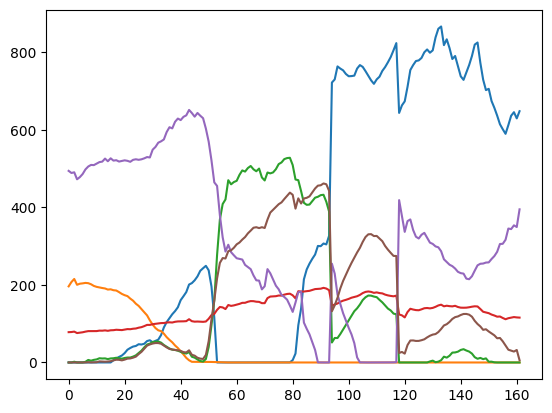

In [45]:
print('evaluation score:',evalCriterion(endmembers,W3_t))
plt.figure(),plt.plot(W3_t)

(<Figure size 640x480 with 1 Axes>,
  <matplotlib.lines.Line2D at 0x1e3b8d22490>])

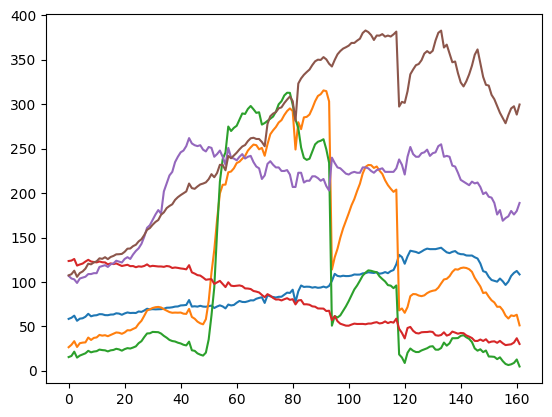

In [46]:
plt.figure(),plt.plot(endmembers)

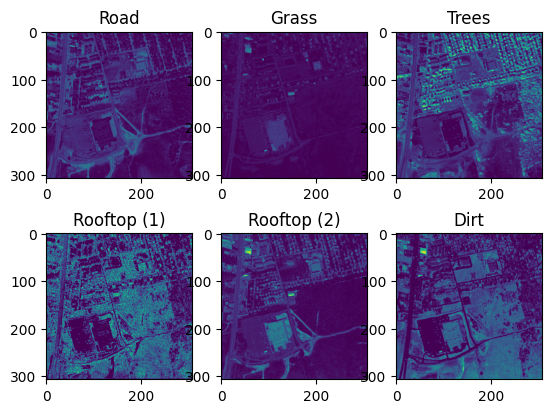

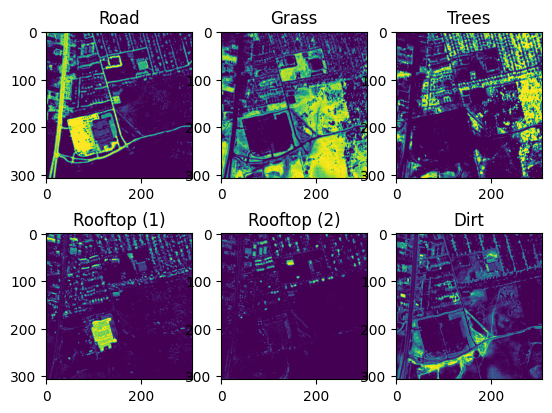

In [47]:
for ii in range(6):
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(H3_t[ii,:].reshape(nCol,nRow))

    plt.title(names[ii])
plt.show()

for ii in range(6):
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(abundances[ii,:].reshape(nCol,nRow))

    plt.title(names[ii])
plt.show()